In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append("../")

In [6]:
import torch
from torch import nn

from models.embedding import SphericalGraphCNN

## Test embedding net

In [7]:
nside_list = [128, 64, 32, 16, 8, 4, 2]

In [8]:
from utils import create_mask as cm

hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.ud_grade(hp_mask_nside1, nside)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])

In [9]:
ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
hp_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25, custom_mask=ps_mask)
hp_mask

array([ True,  True,  True, ...,  True,  True,  True])

/ext3/miniconda3/envs/sbi-fermi/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/ext3/miniconda3/envs/sbi-fermi/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/ext3/miniconda3/envs/sbi-fermi/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you

torch.Size([1, 16384, 1])

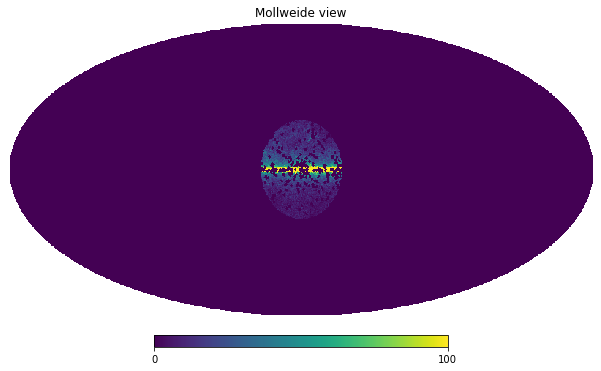

In [10]:
in_map = np.load("../data/fermi_data/fermidata_counts.npy")
in_map[hp_mask] = 0

hp.mollview(in_map, max=100)

in_map = torch.Tensor(in_map[~masks_list[0]])
in_map = in_map.reshape((1, -1, 1))
in_map.shape

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [12]:
sg = SphericalGraphCNN(nside_list, indexes_list).to(device)

In [13]:
in_map.shape

torch.Size([1, 16384, 1])

In [14]:
in_map = in_map.to(device)

In [15]:
sg(in_map).shape

torch.Size([1, 512])

## Test data generation

In [16]:
temp_gce = np.load("../data/fermi_data/template_gce.npy")

In [17]:
from models.scd import dnds
from utils.psf_correction import PSFCorrection
from models.psf import KingPSF

In [18]:
kp = KingPSF()

pc_inst = PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: kp.psf_fermi_r(r)

In [19]:
from simulations.wrapper import simulator

In [20]:
import sys
from sbi import utils
from sbi import inference
from sbi.inference.base import infer

In [21]:
theta = [3, 10., 1.9, -10., 20., 0.1]
simulator(theta, masks_list[0], temp_gce, pc_inst.psf_r_func)

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [22]:
from tqdm import *

In [50]:
# set prior distribution for the parameters 
prior = utils.BoxUniform(low=torch.tensor([0.5, 10.0, 1.1, -10.0, 5.0, 0.1]), high=torch.tensor([3.0, 20.0, 1.99, 1.99, 50.0, 4.99]))

In [51]:
np.sum(~masks_list[0])

16384

In [64]:
number_presimulated = 1000

theta_presimulated = prior.sample((number_presimulated,))
x_presimulated = [simulator(theta.detach().numpy(), masks_list[0], temp_gce, pc_inst.psf_r_func) for theta in tqdm(theta_presimulated)]

100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


In [35]:
# theta_presimulated = np.load("/scratch/sm8383/sbi-fermi/data/samples/theta_train_0.npy")
# x_presimulated = np.load("/scratch/sm8383/sbi-fermi/data/samples/x_train_0.npy")

In [36]:
len(x_presimulated)

100

In [65]:
invalid_idx = np.ones(len(x_presimulated)).astype(np.int32)
for idx in tqdm(range(len(x_presimulated))):
    if np.sum(np.isnan(x_presimulated[idx])) + np.sum(np.isinf(x_presimulated[idx])):
        invalid_idx[idx] = 0

100%|██████████| 10/10 [00:00<00:00, 13025.79it/s]


In [66]:
x_presimulated = np.array(x_presimulated)[invalid_idx.astype(bool)]
theta_presimulated = np.array(theta_presimulated)[invalid_idx.astype(bool)]

In [67]:
len(theta_presimulated)

10

In [41]:
theta_presimulated[:, 0] = np.log10(theta_presimulated[:, 0])

In [42]:
np.save("./x_train.npy", x_presimulated)
np.save("./theta_train.npy", theta_presimulated)

In [77]:
theta_presimulated = torch.Tensor(theta_presimulated)
x_presimulated = torch.Tensor(x_presimulated)

In [25]:
sg_embed = SphericalGraphCNN(nside_list, indexes_list)

## SNPE

In [26]:
from sbi.inference import SNPE

In [27]:
device.type

'cuda'

In [28]:
# instantiate the neural density estimator
neural_classifier = utils.posterior_nn(model='maf',
                                      embedding_net=sg_embed,
                                      hidden_features=50,
                                      num_transforms=4,
)

# setup the inference procedure with the SNPE-C procedure
inference_inst = SNPE(prior=prior, density_estimator=neural_classifier, 
                           show_progress_bars=True, show_round_summary=True, 
                           logging_level='INFO',
                         sample_with_mcmc=False,
                         mcmc_method="slice_np",
                         device=device.type)

../sbi/utils/torchutils.py:31: UserWarning: GPU was selected as a device for training the neural network. Note
                   that we expect **no** significant speed ups in training for the
                   default architectures we provide. Using the GPU will be effective
                   only for large neural networks with operations that are fast on the
                   GPU, e.g., for a CNN or RNN `embedding_net`.
  GPU, e.g., for a CNN or RNN `embedding_net`."""
../sbi/inference/base.py:113: UserWarning: You passed some keyword arguments that will not be used. Specifically, the unused arguments are: ['show_round_summary', 'sample_with_mcmc', 'mcmc_method']. These arguments might have been supported in sbi versions <0.14.0. Since 0.14.0, the API was changed. Please consult the corresponding pull request on github: https://github.com/mackelab/sbi/pull/378 and tutorials: https://www.mackelab.org/sbi/tutorial/02_flexible_interface/ for further information.
  f"You passed some 

In [82]:
density_estimator = inference_inst.train(x="/scratch/sm8383/sbi-fermi/notebooks/x_train.npy",
                                         theta="/scratch/sm8383/sbi-fermi/notebooks/theta_train.npy",
                                         proposal=prior,
                                         training_batch_size=64, max_num_epochs=100)

Neural network successfully converged after 65 epochs.


In [29]:
density_estimator = torch.load("../data/models/vanilla.pt")

In [31]:
posterior = inference_inst.build_posterior(density_estimator)

In [36]:
x_presimulated = torch.Tensor(np.load("../data/samples/x_train_91.npy"))
theta_presimulated = torch.Tensor(np.load("../data/samples/theta_train_91.npy"))

In [45]:
theta_presimulated[:, 0] = np.log10(theta_presimulated[:, 0])

In [46]:
torch.argmax(theta_presimulated[:, 0])

tensor(651)

In [47]:
import corner

In [49]:
truth_idx = 10
x_o = x_presimulated[truth_idx]
posterior_samples = posterior.sample((400,), x=x_o)
corner.corner(posterior_samples, quantiles=(0.16, 0.84), truths=theta_presimulated[truth_idx]);

                        prior support. It may take a long time to collect the remaining
                        400 samples. Consider interrupting (Ctrl-C)
                        and switching to `sample_with_mcmc=True`.


KeyboardInterrupt: 